# Read Data

In [ ]:
# Basics ######################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

# Widgets #####################################################################
import ipywidgets as widgets
from ipywidgets import interact

# Process mining ##############################################################
import pm4py

# Object.log
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# Object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# Algo.discovery
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# vizualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

In [ ]:
log_csv = pd.read_csv('Learning Log_Input.csv', dtype={'ID': object})
log_csv.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,User_ID,Case_Start_Date,Activity_Start_Date,Activity_End_Date,Browser,Operating_System,Device,Country,Visited_Page,Time_on_Page,Sequence
0,hv5xru,12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:00:48,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,168,1
1,hv5xru,12/30/2021 23:58:00,12/31/2021 00:00:48,12/31/2021 00:03:21,ChromeMobile,Android,Mobile,Iran,Visited:.../online-issuance-and-cancellation/,153,2
2,hv5xru,12/30/2021 23:58:00,12/31/2021 00:03:21,12/31/2021 00:03:26,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,5,3
3,hv5xru,12/30/2021 23:58:00,12/31/2021 00:03:26,12/31/2021 00:04:07,ChromeMobile,Android,Mobile,Iran,Visited:.../support/,41,4
4,hv5xru,12/30/2021 23:58:00,12/31/2021 00:04:07,12/31/2021 00:04:33,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,26,5


In [ ]:
log_csv["User_ID"] = log_csv["User_ID"] + "_" + log_csv["Case_Start_Date"]
log_csv.head()

,User_ID,Case_Start_Date,Activity_Start_Date,Activity_End_Date,Browser,Operating_System,Device,Country,Visited_Page,Time_on_Page,Sequence
0,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:00:48,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,168,1
1,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:00:48,12/31/2021 00:03:21,ChromeMobile,Android,Mobile,Iran,Visited:.../online-issuance-and-cancellation/,153,2
2,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:03:21,12/31/2021 00:03:26,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,5,3
3,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:03:26,12/31/2021 00:04:07,ChromeMobile,Android,Mobile,Iran,Visited:.../support/,41,4
4,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:04:07,12/31/2021 00:04:33,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,26,5


In [ ]:
log_csv["Category"] = np.nan
URL_Category = {"/event/": "Event pages",
                "/page/": "Search",
                "/profile/": "Profile",
                "/video/": "Video courses",
                "/landings/": "Landing pages",
                "/tag/": "Tag pages",
                "/encyclopedia/": "Dictionary pages",
                "/question/": "Support Page",
                "Visited:learning.emofid.com": "Home page",
                "/category/": "Category pages",
                "/events/": "Category pages",
                "/articles/": "Category pages",
                "/course/": "Category pages",
                "/events/": "Category pages",
                "/dictionary/": "Category pages",
                "/newsletter/": "News"  }

In [ ]:
for key, value in URL_Category.items():
    mask = log_csv["Visited_Page"].str.contains(key)
    log_csv.loc[mask, "Category"] = value

mask = log_csv['Category'].isnull()
log_csv.loc[mask, "Category"] = "Article"

In [ ]:
i = 0
j = 0

while i < log_csv.shape[0]-1:
    if log_csv.iat[i,0]==log_csv.iat[i+1,0] and log_csv.iat[i,8]==log_csv.iat[i+1,8]:
      log_csv.iat[i,9]+=log_csv.iat[i+1,9]
      log_csv.iat[i,3]=log_csv.iat[i+1,3]
      log_csv = log_csv.drop([j+i+1])
      i-=1
      j+=1
    i+=1
    
log_csv.head()

,User_ID,Case_Start_Date,Activity_Start_Date,Activity_End_Date,Browser,Operating_System,Device,Country,Visited_Page,Time_on_Page,Sequence,Category
0,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:00:48,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,168,1,Home page
1,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:00:48,12/31/2021 00:03:21,ChromeMobile,Android,Mobile,Iran,Visited:.../online-issuance-and-cancellation/,153,2,Article
2,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:03:21,12/31/2021 00:03:26,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,5,3,Home page
3,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:03:26,12/31/2021 00:04:07,ChromeMobile,Android,Mobile,Iran,Visited:.../support/,41,4,Article
4,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:04:07,12/31/2021 00:04:33,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,26,5,Home page


In [ ]:
log_csv=log_csv[log_csv['Time_on_Page']>=10]
log_csv=log_csv[log_csv['Time_on_Page']<=1875]
log_csv.reset_index(inplace=True)
del log_csv["index"]
log_csv.head()

,User_ID,Case_Start_Date,Activity_Start_Date,Activity_End_Date,Browser,Operating_System,Device,Country,Visited_Page,Time_on_Page,Sequence,Category
0,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:00:48,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,168,1,Home page
1,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:00:48,12/31/2021 00:03:21,ChromeMobile,Android,Mobile,Iran,Visited:.../online-issuance-and-cancellation/,153,2,Article
2,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:03:26,12/31/2021 00:04:07,ChromeMobile,Android,Mobile,Iran,Visited:.../support/,41,4,Article
3,hv5xru_12/30/2021 23:58:00,12/30/2021 23:58:00,12/31/2021 00:04:07,12/31/2021 00:04:33,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,26,5,Home page
4,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:09,Firefox,Windows,PC,Iran,Visited:learning.emofid.com,129,1,Home page


In [ ]:
log_csv.describe()

,Time_on_Page
count,56688.000000
mean,283.838661
std,367.836844
min,10.000000
25%,29.000000
50%,112.000000
75%,392.000000
max,1873.000000


In [ ]:
# Check NA-values
log_csv.isna().sum()

User_ID                   0
Case_Start_Date           0
Activity_Start_Date      10
Activity_End_Date        10
Browser                   0
Operating_System          0
Device                    0
Country                   0
Visited_Page              0
Time_on_Page              0
Sequence               4210
Category                  0
dtype: int64

In [ ]:
log_csv = log_csv.dropna()

In [ ]:
# Info
log_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52468 entries, 0 to 56687
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   User_ID              52468 non-null  object
 1   Case_Start_Date      52468 non-null  object
 2   Activity_Start_Date  52468 non-null  object
 3   Activity_End_Date    52468 non-null  object
 4   Browser              52468 non-null  object
 5   Operating_System     52468 non-null  object
 6   Device               52468 non-null  object
 7   Country              52468 non-null  object
 8   Visited_Page         52468 non-null  object
 9   Time_on_Page         52468 non-null  int64 
 10  Sequence             52468 non-null  object
 11  Category             52468 non-null  object
dtypes: int64(1), object(11)
memory usage: 5.2+ MB


In [ ]:
# Export Dataframe
log_csv.to_csv('Learning Log_Output.csv')
files.download("Learning Log_Output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Sample
log_csv2 = log_csv.sample(frac=0.0007).sort_index()
log_csv2.head()

,User_ID,Case_Start_Date,Activity_Start_Date,Activity_End_Date,Browser,Operating_System,Device,Country,Visited_Page,Time_on_Page,Sequence,Category
658,ob73ti_12/30/2021 12:24:00,12/30/2021 12:24:00,12/30/2021 12:24:58,12/30/2021 12:25:08,ChromeMobile,Android,Mobile,Iran,Visited:.../category/investmentknowledge/,10,3,Category pages
976,2sgaps_12/30/2021 07:09:00,12/30/2021 07:09:00,12/30/2021 07:24:08,12/30/2021 07:29:34,ChromeMobile,Android,Mobile,Iran,Visited:.../mofids_funds/,326,12,Article
1704,stxzsl_12/29/2021 18:50:00,12/29/2021 18:50:00,12/29/2021 18:59:51,12/29/2021 19:00:08,ChromeMobile,Android,Mobile,Iran,Visited:.../change-the-supervising-broker-in-e...,17,4,Article
3846,1nwycnx_12/28/2021 23:11:00,12/28/2021 23:11:00,12/28/2021 23:34:42,12/29/2021 00:03:57,Firefox,Windows,PC,Iran,Visited:.../the-birth-of-stock-exchanges-in-iran/,1755,5,Article
7291,6h9b4j_12/27/2021 08:14:00,12/27/2021 08:14:00,12/27/2021 08:15:05,12/27/2021 08:15:15,ChromeMobile,Android,Mobile,Iran,Visited:learning.emofid.com,10,2,Home page


In [ ]:
# Unique values
pd.DataFrame(
    {
        'variable': log_csv.columns, 
        'unique values': [log_csv[col].nunique() for col in log_csv.columns],
        'fraction': [round(log_csv[col].nunique() / log_csv.shape[0], 2) for col in log_csv.columns], 
    }
).set_index('variable')

,unique values,fraction
variable,,
User_ID,10757,0.21
Case_Start_Date,8043,0.15
Activity_Start_Date,49408,0.94
Activity_End_Date,51310,0.98
Browser,14,0.00
Operating_System,7,0.00
Device,4,0.00
Country,37,0.00
Visited_Page,1236,0.02


In [ ]:
log_csv['User_ID']

0         hv5xru_12/30/2021 23:58:00
1         hv5xru_12/30/2021 23:58:00
2         hv5xru_12/30/2021 23:58:00
3         hv5xru_12/30/2021 23:58:00
4         92c26h_12/30/2021 23:57:00
                    ...             
56683    16fyg4n_12/01/2021 00:08:00
56684     9nedrb_12/01/2021 00:04:00
56685     9nedrb_12/01/2021 00:04:00
56686     9nedrb_12/01/2021 00:04:00
56687     9nedrb_12/01/2021 00:04:00
Name: User_ID, Length: 52468, dtype: object

# Value Counts

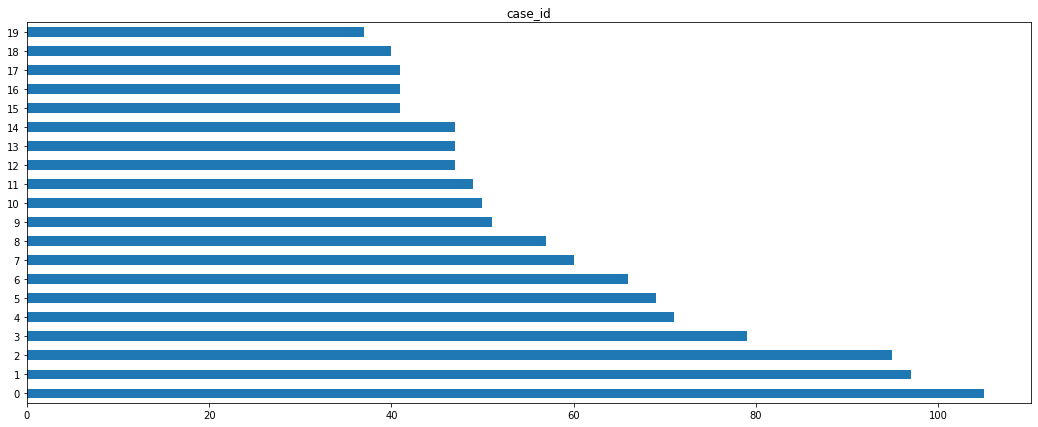

In [ ]:
# User_id
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
log_csv["User_ID"].value_counts().head(20).reset_index(drop=True).plot(y='User_ID', kind='barh', title='case_id')
plt.show()

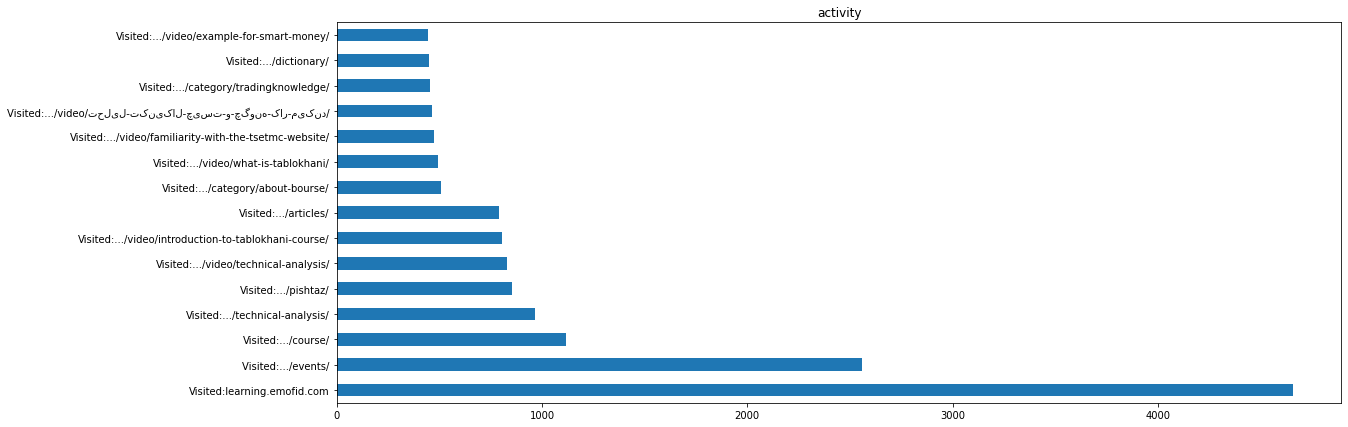

In [ ]:
# Visited Page
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
log_csv['Visited_Page'].value_counts().head(15).plot(y='Visited_Page', kind='barh', title='activity')
plt.show()

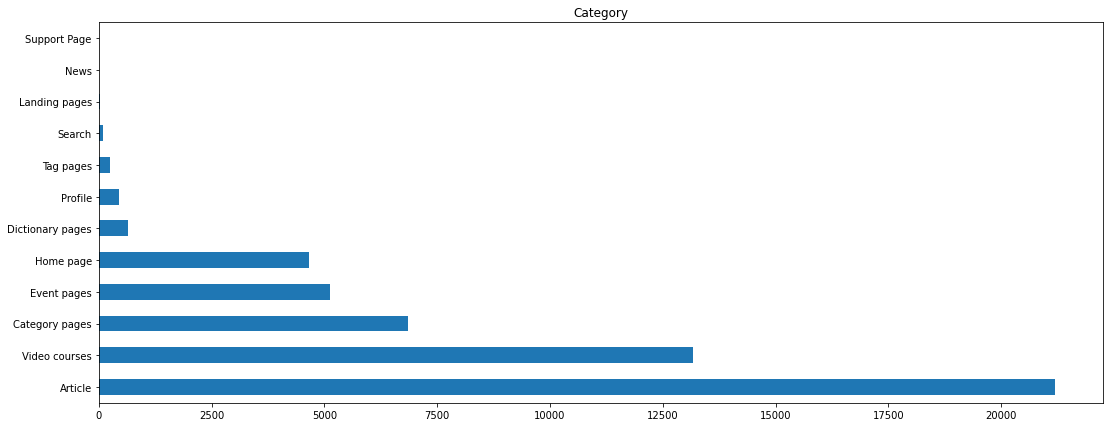

In [ ]:
# Visited Page (Category)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
log_csv['Category'].value_counts().plot(y='Category', kind='barh', title='Category')
plt.show()

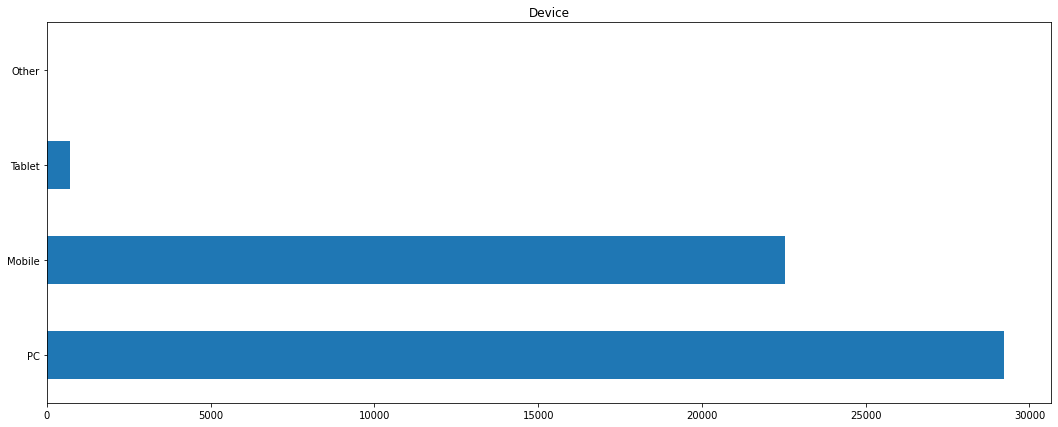

In [ ]:
# Device
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
log_csv['Device'].value_counts().plot(y='Device', kind='barh', title='Device')
plt.show()

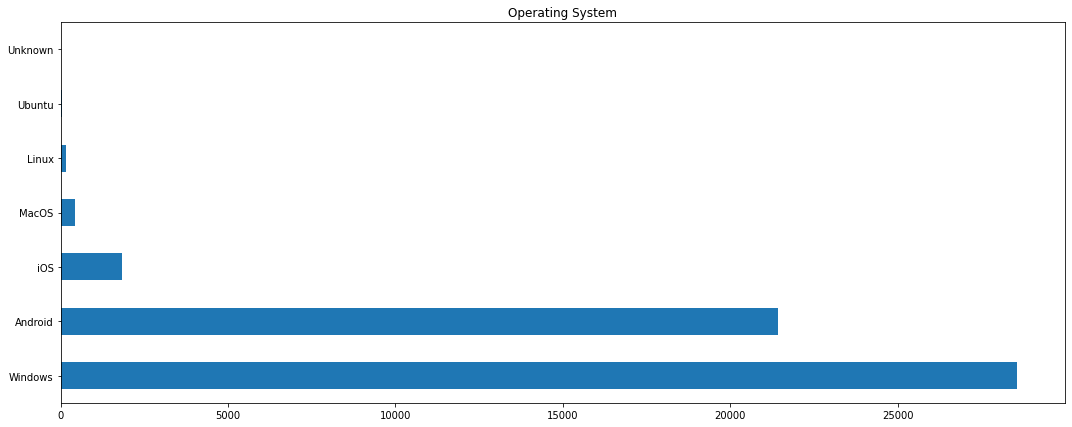

In [ ]:
# Operating System
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
log_csv['Operating_System'].value_counts().plot(y='Operating_System', kind='barh', title='Operating System')
plt.show()

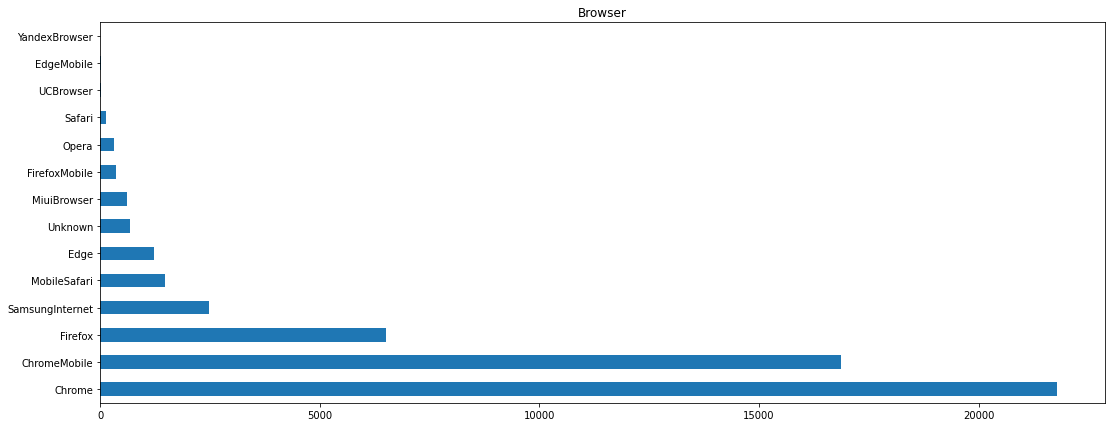

In [ ]:
# Browser
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
log_csv['Browser'].value_counts().plot(y='Browser', kind='barh', title='Browser')
plt.show()

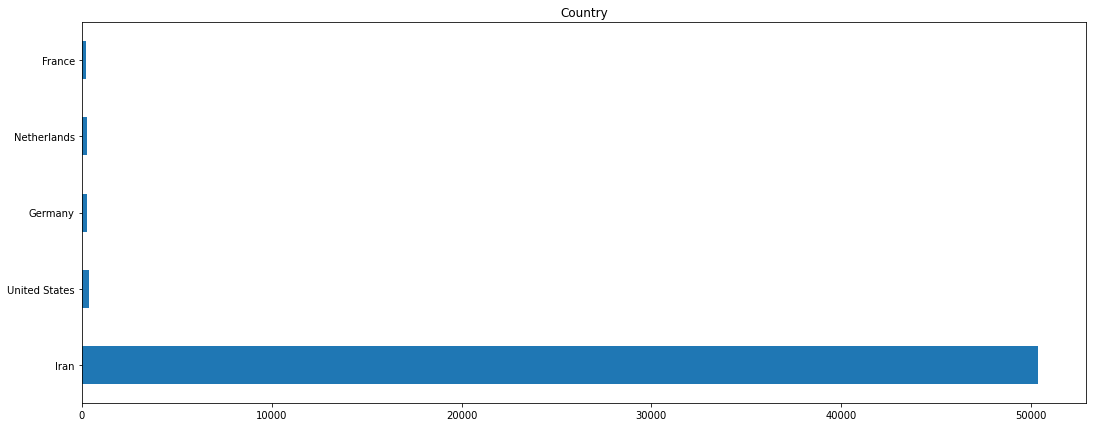

In [ ]:
# Country
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
log_csv['Country'].value_counts().head(5).plot(y='Country', kind='barh', title='Country')
plt.show()

In [ ]:
# Unique values: timestamp
log_csv['Case_Start_Date'].nunique()

8043

In [ ]:
[log_csv['Case_Start_Date'].value_counts() > 1]

[12/21/2021 14:34:00     True
 12/18/2021 14:57:00     True
 12/11/2021 10:00:00     True
 12/01/2021 13:00:00     True
 12/02/2021 08:18:00     True
                        ...  
 12/28/2021 20:25:00    False
 12/02/2021 11:01:00    False
 12/10/2021 23:34:00    False
 12/06/2021 15:10:00    False
 12/26/2021 05:53:00    False
 Name: Case_Start_Date, Length: 8043, dtype: bool]

In [ ]:
# Multiple occurences: timestamp
log_csv['Case_Start_Date'].value_counts()[log_csv['Case_Start_Date'].value_counts() > 1]

12/21/2021 14:34:00    107
12/18/2021 14:57:00    106
12/11/2021 10:00:00     98
12/01/2021 13:00:00     95
12/02/2021 08:18:00     79
                      ... 
12/25/2021 09:48:00      2
12/25/2021 08:30:00      2
12/14/2021 21:17:00      2
12/11/2021 09:10:00      2
12/15/2021 11:12:00      2
Name: Case_Start_Date, Length: 7616, dtype: int64

In [ ]:
log_csv["Category"].unique()

array(['Home page', 'Article', 'Event pages', 'Video courses',
       'Category pages', 'Tag pages', 'Dictionary pages', 'Profile',
       'Landing pages', 'Search', 'News', 'Support Page'], dtype=object)

In [ ]:
list(log_csv.groupby('User_ID').agg(time_start = ('Time_on_Page', min), 
                                               time_end = ('Time_on_Page', max)
                                              ).head(10).reset_index().itertuples(index=False))

[Pandas(User_ID='100od9e_12/21/2021 12:44:00', time_start=14, time_end=191),
 Pandas(User_ID='1018dg1_12/08/2021 09:18:00', time_start=12, time_end=246),
 Pandas(User_ID='1019lyx_12/12/2021 11:11:00', time_start=409, time_end=409),
 Pandas(User_ID='101rbps_12/11/2021 14:40:00', time_start=18, time_end=25),
 Pandas(User_ID='101syhj_12/11/2021 20:55:00', time_start=18, time_end=253),
 Pandas(User_ID='101zppo_12/08/2021 18:04:00', time_start=118, time_end=1199),
 Pandas(User_ID='1026fen_12/01/2021 16:38:00', time_start=15, time_end=1209),
 Pandas(User_ID='1027knu_12/26/2021 12:35:00', time_start=976, time_end=976),
 Pandas(User_ID='102etfu_12/08/2021 12:38:00', time_start=450, time_end=1007),
 Pandas(User_ID='102etfu_12/08/2021 15:59:00', time_start=50, time_end=686)]

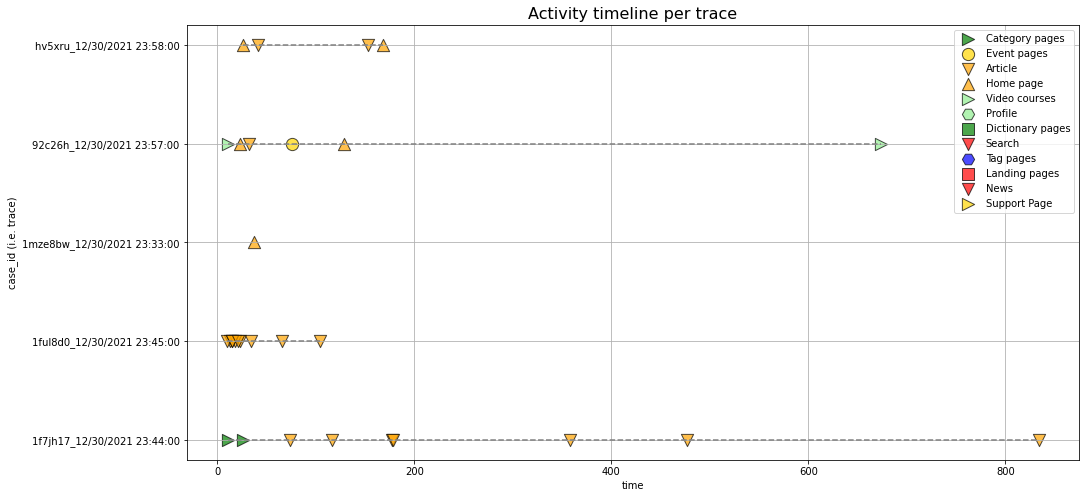

In [ ]:
# Visualize eventlog ##########################################################

# Settings
activity = {
    'Category pages': ('>', 'green'), 
    'Event pages': ('o', 'gold'), 
    'Article': ('v', 'orange'), 
    'Home page': ('^', 'orange'), 
    'Video courses': ('>', 'lightgreen'), 
    'Profile': ('H', 'lightgreen'), 
    'Dictionary pages': ('s', 'green'), 
    'Search': ('v', 'red'),
    'Tag pages': ('H', 'blue'), 
    'Landing pages': ('s', 'red'), 
    'News': ('v', 'red'),
    'Support Page': ('>', 'gold'),

}

# Figure
fig, ax = plt.subplots(figsize=(16, 8))

# Timelines
for timeline in list(log_csv.head(30).groupby('User_ID').agg(time_start = ('Time_on_Page', min), 
                                               time_end = ('Time_on_Page', max)
                                              ).reset_index().itertuples(index=False)):
    plt.hlines(timeline.User_ID, timeline.time_start, timeline.time_end, 
               colors = 'grey', linestyles = 'dashed')

# Activities
for act in activity.keys():
    ax.scatter(log_csv.head(30).loc[log_csv.Category == act, 'Time_on_Page'], 
               log_csv.head(30).loc[log_csv.Category == act, 'User_ID'],
               marker = activity[act][0],
               color = activity[act][1], 
               s = 150, 
               alpha = .7,
               label = act,
               edgecolors = 'black',
              )
    
ax.set_title('Activity timeline per trace', fontsize=16)
ax.set_xlabel('time')
ax.set_ylabel('case_id (i.e. trace)')
ax.legend()
ax.grid(True)

In [ ]:
def dfg_frequency_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph frequency matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events).fillna(0)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
        .drop([case_var, timestamp_var], axis = 1)\
        .rename(columns = {event_var:'event_from'})
        event['event_to'] = event['event_from'].shift(-1)
        event.dropna(inplace = True)
        
        # loop through traces
        for trace in event.itertuples(index = False):
            matrix.at[trace.event_from, trace.event_to] += 1
                
    return matrix.replace(0, np.nan)

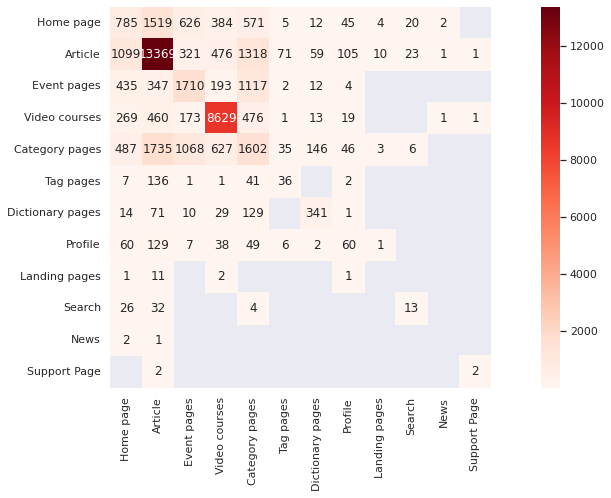

In [ ]:
# Directly-Follows Graph frequency heatmap
dfg_freq_matrix = dfg_frequency_matrix(log_csv, 'User_ID', 'Category', 'Time_on_Page')
sns.set(rc={'figure.figsize':(18, 7)})
sns.heatmap(dfg_freq_matrix, annot=True, fmt='.0f', cmap='Reds', square=True)
plt.show()

In [ ]:
def dfg_performance_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph duration matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    By default duration is set to hours (h). Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    # event log
    log = event_log
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var).rename(columns = {event_var:'event_from', timestamp_var: "time_begin"})
        event['event_to'] = event['event_from'].shift(-1)
        event['time_end'] = event['time_begin'].shift(-1)
        event['duration'] = pd.to_datetime(event['time_end']) - pd.to_datetime(event['time_begin'])
        event.dropna(inplace = True)
        
        # loop through traces
        for row in event.itertuples(index = False):
            matrix.at[row.event_from, row.event_to] = \
            np.nansum([matrix.at[row.event_from, row.event_to], (row.duration).total_seconds() ])
    
    return matrix.astype(float)

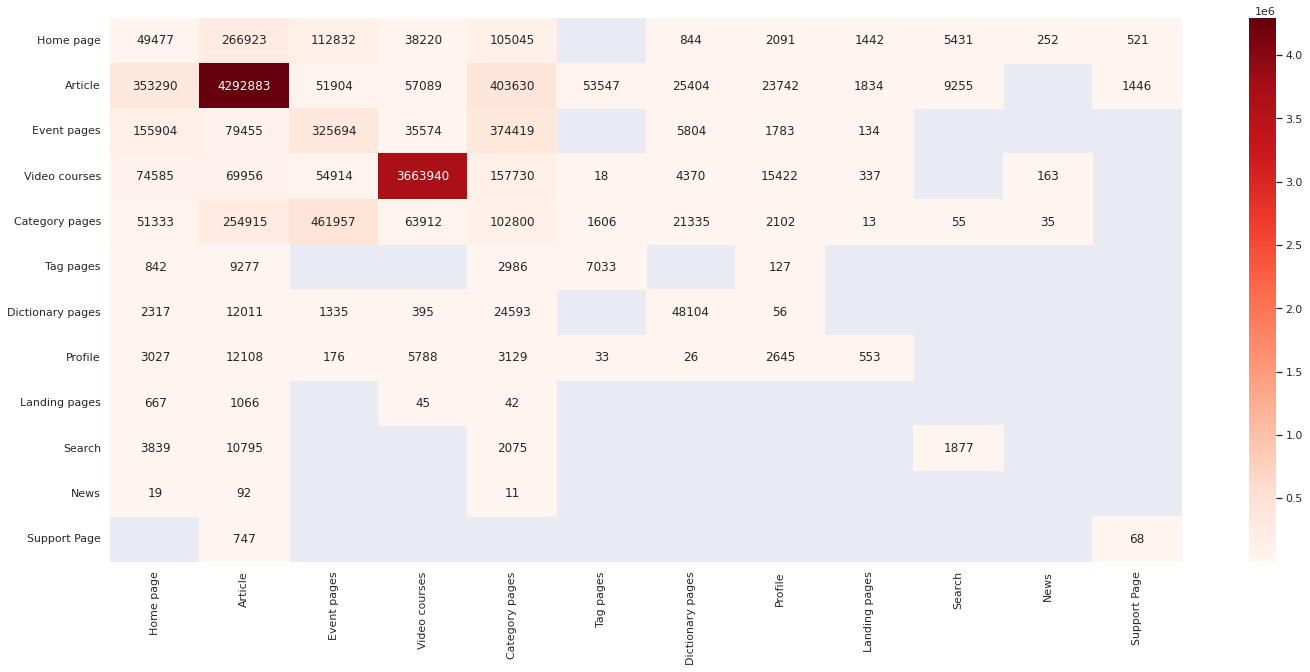

In [ ]:
# Directly-Follows Graph total duration heapmap (in Seconds)
dfg_perf_matrix = dfg_performance_matrix(log_csv, 'User_ID', 'Category', 'Activity_Start_Date', duration='s')
sns.heatmap(dfg_perf_matrix, annot=True, fmt='.0f', cmap='Reds', square=False)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.show()

In [ ]:
def dfg_frequency_table(dfg_frequency_matrix: pd.DataFrame) -> pd.DataFrame:
    
    """
    Returns an directly-follows graph frequency table
    """
    
    arcs = list()
    
    for row in dfg_frequency_matrix.index:
        for col in dfg_frequency_matrix.columns:
            if not np.isnan(dfg_frequency_matrix.at[row, col]):
                arcs.append((row, col, dfg_frequency_matrix.at[row, col]))
    
    arc_freq = pd.DataFrame(arcs, columns = ['event_from', 'event_to', 'frequency'])\
    .set_index(['event_from', 'event_to'])
    
    return arc_freq

In [ ]:
def activity_duration(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:
    
    """
    Returns a dataframe with activity durations (i.e. 'arc' performance decorators).
    By default duration is set to hours (h).
    Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    data = dict()
    groups = log_csv.groupby(case_var)
    for group in groups:
        arc = group[1].sort_values(timestamp_var)\
        .rename(columns = {event_var:'event_from', timestamp_var:'time_from'})
        arc['event_to'] = arc['event_from'].shift(-1)
        arc['time_to'] = arc['time_from'].shift(-1)
        arc.dropna(inplace = True)
        duration_var = f'duration ({duration})'
        arc[duration_var] =  arc['Time_on_Page']
        data[group[0]] = arc[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]]
    return pd.concat(data.values()).set_index(case_var)

In [ ]:
# Directly-Follows Graph frequency and performance (in hours) table
df = pd.merge(
    dfg_frequency_table(dfg_frequency_matrix(log_csv, 'User_ID', 'Category', 'Activity_Start_Date')).reset_index(),
    activity_duration(log_csv, 'User_ID', 'Category', 'Activity_Start_Date').loc[:, ['event_from', 'event_to', 'duration (h)']].groupby(by = ['event_from', 'event_to']).mean('duration').reset_index(),
    left_on = ['event_from', 'event_to'],
    right_on = ['event_from', 'event_to']
).rename(columns = {'duration (h)':'average_duration'})

df['average_duration'] = df['average_duration'].apply(lambda x: np.round(x, decimals=2))
df['frequency'] = df['frequency'].astype(int)
df['total_duration'] = df['frequency'] * df['average_duration']

df.sort_values(['total_duration', 'average_duration', 'frequency'], ascending=False)

,event_from,event_to,frequency,average_duration,total_duration
12,Article,Article,13228,295.19,3904773.32
33,Video courses,Video courses,8844,385.48,3409185.12
42,Category pages,Event pages,1690,271.50,458835.00
15,Article,Category pages,1763,221.32,390187.16
26,Event pages,Category pages,960,382.61,367305.60
...,...,...,...,...,...
68,Profile,Tag pages,1,18.00,18.00
48,Category pages,Landing pages,1,13.00,13.00
69,Profile,Dictionary pages,1,12.00,12.00
82,News,Category pages,1,11.00,11.00


.

# Recommendation Algorithms

Creating Rating Matrix

In [ ]:
"""
df_1: There are only rows with a category of "Video courses" or "Event pages"
df_2: There are Cases that at least one of their events is "Video courses" or "Event pages"

"""

cats = ['Video courses', 'Event pages']
df_1 = log_csv[log_csv.Category.isin(cats)]

df_2 = copy.deepcopy(log_csv)
for i in df_2.User_ID.unique():
  if (df_2[df_2.User_ID == i].Category == 'Video courses').sum() + (df_2[df_2.User_ID == i].Category == 'Event pages').sum() == 0:
    df_2 = df_2.drop(df_2[df_2.User_ID == i].index)

In [ ]:
# Choosing one DataFrame from df_1 or df_2

Rating_df = copy.deepcopy(df_2)
Rating_df.reset_index(inplace=True)
del Rating_df["index"]

Rating_df.head()

,User_ID,Case_Start_Date,Activity_Start_Date,Activity_End_Date,Browser,Operating_System,Device,Country,Visited_Page,Time_on_Page,Sequence,Category
0,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:09,Firefox,Windows,PC,Iran,Visited:learning.emofid.com,129,1,Home page
1,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:09,12/30/2021 23:59:41,Firefox,Windows,PC,Iran,Visited:.../bambo/,32,2,Article
2,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:41,12/31/2021 00:00:04,Firefox,Windows,PC,Iran,Visited:learning.emofid.com,23,3,Home page
3,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/31/2021 00:00:04,12/31/2021 00:01:20,Firefox,Windows,PC,Iran,Visited:.../event/rights-issues-strategy-8day/,76,4,Event pages
4,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/31/2021 00:01:20,12/31/2021 00:01:31,Firefox,Windows,PC,Iran,Visited:.../video/introduction-to-tablokhani-c...,11,5,Video courses


In [ ]:
Rating_df.loc[Rating_df.Time_on_Page > 500, "Time_on_Page"] = 500

Calcaulating confidence_value

In [ ]:
def confidence_value (dataset , Index_of_CaseId_Column , alfa):
  S_cp = []
  for i in range(dataset.shape[0]):
    a = sum(dataset.iloc[:i+1, Index_of_CaseId_Column] == dataset.iloc[i, 0]) * alfa / sum(dataset.iloc[:, Index_of_CaseId_Column] == dataset.iloc[i, 0])
    S_cp.append(a)
  
  dataset["confidence_value"] = S_cp

In [ ]:
confidence_value(dataset = Rating_df , Index_of_CaseId_Column = 0, alfa = 1)

In [ ]:
Rating_df.head()

,User_ID,Case_Start_Date,Activity_Start_Date,Activity_End_Date,Browser,Operating_System,Device,Country,Visited_Page,Time_on_Page,Sequence,Category,confidence_value
0,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:09,Firefox,Windows,PC,Iran,Visited:learning.emofid.com,129,1,Home page,0.166667
1,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:09,12/30/2021 23:59:41,Firefox,Windows,PC,Iran,Visited:.../bambo/,32,2,Article,0.333333
2,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:41,12/31/2021 00:00:04,Firefox,Windows,PC,Iran,Visited:learning.emofid.com,23,3,Home page,0.500000
3,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/31/2021 00:00:04,12/31/2021 00:01:20,Firefox,Windows,PC,Iran,Visited:.../event/rights-issues-strategy-8day/,76,4,Event pages,0.666667
4,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/31/2021 00:01:20,12/31/2021 00:01:31,Firefox,Windows,PC,Iran,Visited:.../video/introduction-to-tablokhani-c...,11,5,Video courses,0.833333


In [ ]:
Rating_df['Score'] = Rating_df['confidence_value']
Rating_df.head()

,User_ID,Case_Start_Date,Activity_Start_Date,Activity_End_Date,Browser,Operating_System,Device,Country,Visited_Page,Time_on_Page,Sequence,Category,confidence_value,Score
0,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:09,Firefox,Windows,PC,Iran,Visited:learning.emofid.com,129,1,Home page,0.166667,0.166667
1,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:09,12/30/2021 23:59:41,Firefox,Windows,PC,Iran,Visited:.../bambo/,32,2,Article,0.333333,0.333333
2,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/30/2021 23:59:41,12/31/2021 00:00:04,Firefox,Windows,PC,Iran,Visited:learning.emofid.com,23,3,Home page,0.500000,0.500000
3,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/31/2021 00:00:04,12/31/2021 00:01:20,Firefox,Windows,PC,Iran,Visited:.../event/rights-issues-strategy-8day/,76,4,Event pages,0.666667,0.666667
4,92c26h_12/30/2021 23:57:00,12/30/2021 23:57:00,12/31/2021 00:01:20,12/31/2021 00:01:31,Firefox,Windows,PC,Iran,Visited:.../video/introduction-to-tablokhani-c...,11,5,Video courses,0.833333,0.833333


**ALS Model**

 - M1:

In [ ]:
Rating_df = Rating_df.drop(['Case_Start_Date', 'Activity_Start_Date', 'Activity_End_Date', 'Browser', 'Operating_System', 'Device', 'Country', 'Category'], axis = 1)
Rating_df.head()

,User_ID,Visited_Page,Time_on_Page,Sequence,confidence_value,Score
0,92c26h_12/30/2021 23:57:00,Visited:learning.emofid.com,129,1,0.166667,0.166667
1,92c26h_12/30/2021 23:57:00,Visited:.../bambo/,32,2,0.333333,0.333333
2,92c26h_12/30/2021 23:57:00,Visited:learning.emofid.com,23,3,0.500000,0.500000
3,92c26h_12/30/2021 23:57:00,Visited:.../event/rights-issues-strategy-8day/,76,4,0.666667,0.666667
4,92c26h_12/30/2021 23:57:00,Visited:.../video/introduction-to-tablokhani-c...,11,5,0.833333,0.833333


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

In [ ]:
from pyspark.sql.types import *

schema = StructType([StructField("User_ID", StringType(), True)\
                   ,StructField("Visited_Page", StringType(), True)\
                   ,StructField("Time_on_Page", IntegerType(), True)\
                   ,StructField("Sequence", StringType(), True)\
                   ,StructField("confidence_value", FloatType(), True)\
                   ,StructField("Score", FloatType(), True)])


#create spark dataframe using schema
sparkDF = spark.createDataFrame(Rating_df, schema=schema)
sparkDF.show(8)

+--------------------+--------------------+------------+--------+----------------+----------+
|             User_ID|        Visited_Page|Time_on_Page|Sequence|confidence_value|     Score|
+--------------------+--------------------+------------+--------+----------------+----------+
|92c26h_12/30/2021...|Visited:learning....|         129|       1|      0.16666667|0.16666667|
|92c26h_12/30/2021...|  Visited:.../bambo/|          32|       2|      0.33333334|0.33333334|
|92c26h_12/30/2021...|Visited:learning....|          23|       3|             0.5|       0.5|
|92c26h_12/30/2021...|Visited:.../event...|          76|       4|       0.6666667| 0.6666667|
|92c26h_12/30/2021...|Visited:.../video...|          11|       5|       0.8333333| 0.8333333|
|92c26h_12/30/2021...|Visited:.../video...|         500|       6|             1.0|       1.0|
|ba25zq_12/30/2021...|Visited:.../video...|         364|       1|            0.25|      0.25|
|ba25zq_12/30/2021...|Visited:.../video...|         490|    

In [ ]:
# Select appropriate columns
nd = sparkDF.select(sparkDF['Visited_Page'],sparkDF['Score'],sparkDF['User_ID'])
nd.show(8)

+--------------------+----------+--------------------+
|        Visited_Page|     Score|             User_ID|
+--------------------+----------+--------------------+
|Visited:learning....|0.16666667|92c26h_12/30/2021...|
|  Visited:.../bambo/|0.33333334|92c26h_12/30/2021...|
|Visited:learning....|       0.5|92c26h_12/30/2021...|
|Visited:.../event...| 0.6666667|92c26h_12/30/2021...|
|Visited:.../video...| 0.8333333|92c26h_12/30/2021...|
|Visited:.../video...|       1.0|92c26h_12/30/2021...|
|Visited:.../video...|      0.25|ba25zq_12/30/2021...|
|Visited:.../video...|       0.5|ba25zq_12/30/2021...|
+--------------------+----------+--------------------+
only showing top 8 rows



In [ ]:
# Importing important modules
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [ ]:
# Converting String to index
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(nd.columns)-set(['Score'])) ]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(nd).transform(nd)
transformed.show(8)

+--------------------+----------+--------------------+------------------+-------------+
|        Visited_Page|     Score|             User_ID|Visited_Page_index|User_ID_index|
+--------------------+----------+--------------------+------------------+-------------+
|Visited:learning....|0.16666667|92c26h_12/30/2021...|               0.0|       1297.0|
|  Visited:.../bambo/|0.33333334|92c26h_12/30/2021...|             172.0|       1297.0|
|Visited:learning....|       0.5|92c26h_12/30/2021...|               0.0|       1297.0|
|Visited:.../event...| 0.6666667|92c26h_12/30/2021...|             123.0|       1297.0|
|Visited:.../video...| 0.8333333|92c26h_12/30/2021...|               4.0|       1297.0|
|Visited:.../video...|       1.0|92c26h_12/30/2021...|               5.0|       1297.0|
|Visited:.../video...|      0.25|ba25zq_12/30/2021...|              77.0|       2973.0|
|Visited:.../video...|       0.5|ba25zq_12/30/2021...|             125.0|       2973.0|
+--------------------+----------

In [ ]:
# Creating training and test data
(training,test) = transformed.randomSplit([0.9, 0.1])

In [ ]:
# Creating ALS model and fitting data
als = ALS(maxIter=5,regParam=0.09,rank=25,userCol="User_ID_index",itemCol="Visited_Page_index",ratingCol="Score",coldStartStrategy="drop",nonnegative=True)
model=als.fit(training)

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse",labelCol="Score",predictionCol="prediction")
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print("RMSE=" + str(rmse))
print('-' * 30)
predictions.show(8)

RMSE=0.3473648811890127
------------------------------
+--------------------+----------+--------------------+------------------+-------------+----------+
|        Visited_Page|     Score|             User_ID|Visited_Page_index|User_ID_index|prediction|
+--------------------+----------+--------------------+------------------+-------------+----------+
| Visited:.../course/|       0.2|7jpyej_12/13/2021...|               2.0|       1959.0| 0.4345508|
|Visited:.../event...| 0.5555556|1rtxmuv_12/28/202...|             118.0|        471.0|0.54960656|
|Visited:.../event...|       1.0|npq96j_12/27/2021...|              97.0|       2142.0| 0.3815779|
|Visited:.../event...|       1.0|15vaerz_12/28/202...|             103.0|       2366.0|0.40558848|
|Visited:.../event...|0.22222222|6o0p3k_12/14/2021...|              41.0|        496.0|0.56568676|
|Visited:.../inves...|       1.0|1kosuf1_12/18/202...|              32.0|        463.0|0.41693765|
|Visited:.../video...|0.22222222|1kosuf1_12/18/202...|

In [ ]:
# Converting back to string form

Number_Of_Recommendations = 5

import pandas as pd
recs = model.recommendForAllUsers(Number_Of_Recommendations).toPandas()
nrecs=recs.recommendations.apply(pd.Series) \
            .merge(recs, right_index = True, left_index = True) \
            .drop(["recommendations"], axis = 1) \
            .melt(id_vars = ['User_ID_index'], value_name = "recommendation") \
            .drop("variable", axis = 1) \
            .dropna() 
nrecs=nrecs.sort_values('User_ID_index')
nrecs=pd.concat([nrecs['recommendation'].apply(pd.Series), nrecs['User_ID_index']], axis = 1)
nrecs.columns = [
        
        'ProductID_index',
        'Rating',
        'UserID_index'
     ]
md=transformed.select(transformed['User_ID'],transformed['User_ID_index'],transformed['Visited_Page'],transformed['Visited_Page_index'])
md=md.toPandas()
dict1 =dict(zip(md['User_ID_index'],md['User_ID']))
dict2=dict(zip(md['Visited_Page_index'],md['Visited_Page']))
nrecs['User_ID']=nrecs['UserID_index'].map(dict1)
nrecs['Visited_Page']=nrecs['ProductID_index'].map(dict2)
nrecs=nrecs.sort_values('User_ID')
nrecs.reset_index(drop=True, inplace=True)
new=nrecs[['User_ID','Visited_Page','Rating']]
new['recommendations'] = list(zip(new.Visited_Page, new.Rating))
res=new[['User_ID','recommendations']]  
res_new=res['recommendations'].groupby([res.User_ID]).apply(list).reset_index()
res_new

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,User_ID,recommendations
0,1018dg1_12/08/2021 09:18:00,"[(Visited:.../ipo/, 0.9187278747558594), (Visi..."
1,101zppo_12/08/2021 18:04:00,"[(Visited:.../encyclopedia/ادغام-و-تملیک/, 0.7..."
2,1026fen_12/01/2021 16:38:00,"[(Visited:.../tag/سفارش-خرید/, 0.8024173378944..."
3,1038ex2_12/02/2021 09:43:00,[(Visited:.../how-to-activate-tabaeis-option-s...
4,103bd53_12/26/2021 10:53:00,[(Visited:.../video/issuance-and-cancellation-...
...,...,...
5991,zx35c8_12/18/2021 14:11:00,[(Visited:.../video/مثال-افزایش-سرمایه-بخش-دوم...
5992,zxl2ru_12/08/2021 16:22:00,"[(Visited:.../vwap-indicator/, 0.7316719889640..."
5993,zyrtod_12/08/2021 19:47:00,"[(Visited:.../tag/سفارش-خرید/, 0.7280409336090..."
5994,zyue7v_12/29/2021 13:46:00,[(Visited:.../6-point-of-that-must-know-about-...


In [ ]:
def Recommended_Pages (data):

  Recommended_Pages = []
  for i in range(res_new.shape[0]):
    a = []
    for j in range(len(res_new.iloc[0, 1])):
      a = []
      a.append(res_new.iloc[i, 0])
      a.append(res_new.iloc[i, 1][j][0])
      a.append(res_new.iloc[i, 1][j][1])
      Recommended_Pages.append(a)
    
  return pd.DataFrame(Recommended_Pages, columns = ['User_ID', 'Predicted_Page', 'Score'])
  

In [ ]:
res_new = Recommended_Pages(res_new)

In [ ]:
res_new.head(8)

,User_ID,Predicted_Page,Score
0,1018dg1_12/08/2021 09:18:00,Visited:.../ipo/,0.918728
1,1018dg1_12/08/2021 09:18:00,Visited:.../how-to-activate-tabaeis-option-sale/,0.942520
2,1018dg1_12/08/2021 09:18:00,Visited:.../6-point-of-that-must-know-about-th...,1.008234
3,1018dg1_12/08/2021 09:18:00,Visited:.../introduction-to-easy-filter/,0.901973
4,1018dg1_12/08/2021 09:18:00,Visited:.../steps-of-buying-in-iran-mercantile...,0.895878
5,101zppo_12/08/2021 18:04:00,Visited:.../encyclopedia/ادغام-و-تملیک/,0.779748
6,101zppo_12/08/2021 18:04:00,Visited:.../6-point-of-that-must-know-about-th...,0.737791
7,101zppo_12/08/2021 18:04:00,Visited:.../how-to-calculate-inflation/,0.803479


- M2:

In [ ]:
df_4 = copy.deepcopy(Rating_df)
del df_4['Time_on_Page']
del df_4['Sequence']
del df_4['confidence_value']
df_4

,User_ID,Visited_Page,Score
0,92c26h_12/30/2021 23:57:00,Visited:learning.emofid.com,0.166667
1,92c26h_12/30/2021 23:57:00,Visited:.../bambo/,0.333333
2,92c26h_12/30/2021 23:57:00,Visited:learning.emofid.com,0.500000
3,92c26h_12/30/2021 23:57:00,Visited:.../event/rights-issues-strategy-8day/,0.666667
4,92c26h_12/30/2021 23:57:00,Visited:.../video/introduction-to-tablokhani-c...,0.833333
...,...,...,...
28562,16fyg4n_12/01/2021 00:08:00,Visited:.../video/افزایش-سرمایه-از-محل-آورده-ن...,0.200000
28563,16fyg4n_12/01/2021 00:08:00,Visited:.../video/افزایش-سرمایه-از-محل-صرف-سهام/,0.400000
28564,16fyg4n_12/01/2021 00:08:00,Visited:.../video/چه-زمانی-سهام-جایزه-قابلیت-ف...,0.600000
28565,16fyg4n_12/01/2021 00:08:00,Visited:.../video/محاسبه-قیمت-تئوریک-سهم-بعد-ا...,0.800000


In [ ]:
customers = list(np.sort(df_4.User_ID.unique())) # Get our unique customers
products = list(df_4.Visited_Page.unique()) # Get our unique products that were purchased
quantity = list(df_4.Score) # All of our purchases

rows = df_4.User_ID.astype(dtype = 'category').cat.codes 
# Get the associated row indices
cols = df_4.Visited_Page.astype(dtype = 'category').cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

In [ ]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.52380376555377

In [ ]:
import random
def make_train(ratings, pct_test = 0.2):

    test_set = ratings.copy()
    test_set[test_set != 0] = 1
    training_set = ratings.copy()
    nonzero_inds = training_set.nonzero()
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    random.seed(0)
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))
    samples = random.sample(nonzero_pairs, num_samples)
    user_inds = [index[0] for index in samples]
    item_inds = [index[1] for index in samples]
    training_set[user_inds, item_inds] = 0
    training_set.eliminate_zeros()
    return training_set, test_set, list(set(user_inds))

In [ ]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

In [ ]:
def implicit_weighted_ALS(training_set, lambda_val = 0.1, alpha = 40, iterations = 10, rank_size = 20, seed = 0):
   
    # first set up our confidence matrix
    
    conf = (alpha*training_set)
    num_user = conf.shape[0]
    num_item = conf.shape[1]
    
    # initialize our X/Y feature vectors randomly with a set seed
    rstate = np.random.RandomState(seed)
    
    X = sparse.csr_matrix(rstate.normal(size = (num_user, rank_size))) # Random numbers in a m x rank shape
    Y = sparse.csr_matrix(rstate.normal(size = (num_item, rank_size))) # Normally this would be rank x n but we can 
    
    # transpose at the end. Makes calculation more simple.
    X_eye = sparse.eye(num_user)
    Y_eye = sparse.eye(num_item)
    lambda_eye = lambda_val * sparse.eye(rank_size) # Our regularization term lambda*I. 
    
    # We can compute this before iteration starts. 
    
    # Begin iterations
   
    for iter_step in range(iterations): # Iterate back and forth between solving X given fixed Y and vice versa
        # Compute yTy and xTx at beginning of each iteration to save computing time
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Being iteration to solve for X based on fixed Y
        for u in range(num_user):
            conf_samp = conf[u,:].toarray() # Grab user row from confidence matrix and convert to dense
            pref = conf_samp.copy() 
            pref[pref != 0] = 1 # Create binarized preference vector 
            CuI = sparse.diags(conf_samp, [0]) # Get Cu - I term, which is just CuI since we never added 1
            yTCuIY = Y.T.dot(CuI).dot(Y) # This is the yT(Cu-I)Y term 
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # This is the yTCuPu term, where we add the eye back in
                                                      # Cu - I + I = Cu
            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu) 
            # Solve for Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, equation 4 from the paper  
        # Begin iteration to solve for Y based on fixed X 
        for i in range(num_item):
            conf_samp = conf[:,i].T.toarray() # transpose to get it in row format and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CiI = sparse.diags(conf_samp, [0]) # Get Ci - I term, which is just CiI since we never added 1
            xTCiIX = X.T.dot(CiI).dot(X) # This is the xT(Cu-I)X term
            xTCiPi = X.T.dot(CiI + X_eye).dot(pref.T) # This is the xTCiPi term
            Y[i] = spsolve(xTx + xTCiIX + lambda_eye, xTCiPi)
            # Solve for Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi, equation 5 from the paper
    # End iterations
    return X, Y.T # Transpose at the end to make up for not being transposed at the beginning. 
                         # Y needs to be rank x n. Keep these as separate matrices for scale reasons. 

In [ ]:
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 15, iterations = 1, rank_size = 20)

In [ ]:
from sklearn import metrics

def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)   

In [ ]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
       
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
      # try:
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score

      # except ValueError:
      #   continue

    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [ ]:
calc_mean_auc(product_train, product_users_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix.transpose(sparse.csr_matrix(item_vecs.T))], product_test)
# AUC for our recommender system

(0.764, 0.921)

.

BPR

In [ ]:
import sys
import numpy as np
import pandas as pd
from math import ceil
from tqdm import trange
from subprocess import call
from itertools import islice
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, dok_matrix

In [ ]:
def create_matrix(data, users_col, items_col, ratings_col, threshold = None):

    if threshold is not None:
        data = data[data[ratings_col] >= threshold]
        data[ratings_col] = 1
    
    for col in (items_col, users_col, ratings_col):
        data[col] = data[col].astype('category')

    ratings = csr_matrix((data[ratings_col],(data[users_col].cat.codes, data[items_col].cat.codes)))
    ratings.eliminate_zeros()
    return ratings, data

In [ ]:
Rating_df.head()

,User_ID,Visited_Page,Time_on_Page,Sequence,confidence_value,Score
0,92c26h_12/30/2021 23:57:00,Visited:learning.emofid.com,129,1,0.166667,0.166667
1,92c26h_12/30/2021 23:57:00,Visited:.../bambo/,32,2,0.333333,0.333333
2,92c26h_12/30/2021 23:57:00,Visited:learning.emofid.com,23,3,0.500000,0.500000
3,92c26h_12/30/2021 23:57:00,Visited:.../event/rights-issues-strategy-8day/,76,4,0.666667,0.666667
4,92c26h_12/30/2021 23:57:00,Visited:.../video/introduction-to-tablokhani-c...,11,5,0.833333,0.833333


In [ ]:
items_col = 'Visited_Page'
users_col = 'User_ID'
ratings_col = 'Score'
threshold = 0
X, df1 = create_matrix(Rating_df, users_col, items_col, ratings_col, threshold)
X

<6051x820 sparse matrix of type '<class 'numpy.longlong'>'
	with 23628 stored elements in Compressed Sparse Row format>

In [ ]:
def create_train_test(ratings, test_size = 0.2, seed = 1234):

    assert test_size < 1.0 and test_size > 0.0

    train = ratings.copy().todok()
    test = dok_matrix(train.shape)
    
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [ ]:
X_train, X_test = create_train_test(X, test_size = 0.2, seed = 1234)

In [ ]:
class BPR:
   
    def __init__(self, learning_rate = 0.01, n_factors = 15, n_iters = 10, 
                 batch_size = 1000, reg = 0.01, seed = 1234, verbose = True):
        self.reg = reg
        self.seed = seed
        self.verbose = verbose
        self.n_iters = n_iters
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # to avoid re-computation at predict
        self._prediction = None
        
    def fit(self, ratings):
        indptr = ratings.indptr
        indices = ratings.indices
        n_users, n_items = ratings.shape
        batch_size = self.batch_size

        if n_users < batch_size:
            batch_size = n_users
            sys.stderr.write('WARNING: Batch size is greater than number of users,'
                             'switching to a batch size of {}\n'.format(n_users))

        batch_iters = n_users // batch_size
        
        # initialize random weights
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size = (n_users, self.n_factors))
        self.item_factors = rstate.normal(size = (n_items, self.n_factors))
        
        # progress bar for training iteration if verbose is turned on
        loop = range(self.n_iters)
        if self.verbose:
            loop = trange(self.n_iters, desc = self.__class__.__name__)
        
        for _ in loop:
            for _ in range(batch_iters):
                sampled = self._sample(n_users, n_items, indices, indptr)
                sampled_users, sampled_pos_items, sampled_neg_items = sampled
                self._update(sampled_users, sampled_pos_items, sampled_neg_items)

        return self
    
    def _sample(self, n_users, n_items, indices, indptr):
        sampled_pos_items = np.zeros(self.batch_size, dtype = np.int)
        sampled_neg_items = np.zeros(self.batch_size, dtype = np.int)
        sampled_users = np.random.choice(
            n_users, size = self.batch_size, replace = False)

        for idx, user in enumerate(sampled_users):
          try:
            pos_items = indices[indptr[user]:indptr[user + 1]]
            pos_item = np.random.choice(pos_items)
            neg_item = np.random.choice(n_items)
          
          except ValueError:
            continue

            while neg_item in pos_items:
                neg_item = np.random.choice(n_items)

            sampled_pos_items[idx] = pos_item
            sampled_neg_items[idx] = neg_item

        return sampled_users, sampled_pos_items, sampled_neg_items
                
    def _update(self, u, i, j):
        user_u = self.user_factors[u]
        item_i = self.item_factors[i]
        item_j = self.item_factors[j]
        
        r_uij = np.sum(user_u * (item_i - item_j), axis = 1)
        sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))
        
        # repeat the 1 dimension sigmoid n_factors times so
        # the dimension will match when doing the update
        sigmoid_tiled = np.tile(sigmoid, (self.n_factors, 1)).T

        # update using gradient descent
        grad_u = sigmoid_tiled * (item_j - item_i) + self.reg * user_u
        grad_i = sigmoid_tiled * -user_u + self.reg * item_i
        grad_j = sigmoid_tiled * user_u + self.reg * item_j
        self.user_factors[u] -= self.learning_rate * grad_u
        self.item_factors[i] -= self.learning_rate * grad_i
        self.item_factors[j] -= self.learning_rate * grad_j
        return self

    def predict(self):
        if self._prediction is None:
            self._prediction = self.user_factors.dot(self.item_factors.T)
        return self._prediction

    def _predict_user(self, user):
        user_pred = self.user_factors[user].dot(self.item_factors.T)
        return user_pred

    def recommend(self, ratings, N = 5):
        n_users = ratings.shape[0]
        recommendation = np.zeros((n_users, N), dtype = np.uint32)
        for user in range(n_users):
            top_n = self._recommend_user(ratings, user, N)
            recommendation[user] = top_n

        return recommendation

    def _recommend_user(self, ratings, user, N):
        scores = self._predict_user(user)
        liked = set(ratings[user].indices)
        count = N + len(liked)
        if count < scores.shape[0]:

            ids = np.argpartition(scores, -count)[-count:]
            best_ids = np.argsort(scores[ids])[::-1]
            best = ids[best_ids]
        else:
            best = np.argsort(scores)[::-1]

        top_n = list(islice((rec for rec in best if rec not in liked), N))
        return top_n
    
    def get_similar_items(self, N = 5, item_ids = None):
        normed_factors = normalize(self.item_factors)
        knn = NearestNeighbors(n_neighbors = N + 1, metric = 'euclidean')
        knn.fit(normed_factors)

        if item_ids is not None:
            normed_factors = normed_factors[item_ids]

        _, items = knn.kneighbors(normed_factors)
        similar_items = items[:, 1:].astype(np.uint32)
        return similar_items

In [ ]:
bpr_params = {'reg': 0.01,
              'learning_rate': 0.1,
              'n_iters': 160,
              'n_factors': 15,
              'batch_size': 10}

bpr = BPR(**bpr_params)
bpr.fit(X_train)

BPR: 100%|██████████| 160/160 [00:35<00:00,  4.48it/s]


In [ ]:
def auc_score(model, ratings):
    auc = 0.0
    b = 0
    n_users, n_items = ratings.shape
    for user, row in enumerate(ratings):
        y_pred = model._predict_user(user)
        y_true = np.zeros(n_items)
        y_true[row.indices] = 1
        try:
          auc += roc_auc_score(y_true, y_pred)
  
        except ValueError:
          b += 1
          continue

    auc /= (n_users - b)
    return auc

In [ ]:
print('auc_score (train): ', auc_score(bpr, X_train))
print('auc_score (test): ', auc_score(bpr, X_test))

auc_score (train):  0.5026566122539141
auc_score (test):  0.49680923328837534


In [ ]:
bpr.recommend(X_train, N = 4)

array([[753, 375,  24, 461],
       [571, 586, 793, 231],
       [622, 253, 158, 796],
       ...,
       [804,   9,  64, 346],
       [542, 547, 627, 174],
       [112, 488, 217, 745]], dtype=uint32)

,User_ID,Visited_Page,Score
0,92c26h_12/30/2021 23:57:00,Visited:learning.emofid.com,0.166667
1,92c26h_12/30/2021 23:57:00,Visited:.../bambo/,0.333333
2,92c26h_12/30/2021 23:57:00,Visited:learning.emofid.com,0.500000
3,92c26h_12/30/2021 23:57:00,Visited:.../event/rights-issues-strategy-8day/,0.666667
4,92c26h_12/30/2021 23:57:00,Visited:.../video/introduction-to-tablokhani-c...,0.833333
...,...,...,...
28562,16fyg4n_12/01/2021 00:08:00,Visited:.../video/افزایش-سرمایه-از-محل-آورده-ن...,0.200000
28563,16fyg4n_12/01/2021 00:08:00,Visited:.../video/افزایش-سرمایه-از-محل-صرف-سهام/,0.400000
28564,16fyg4n_12/01/2021 00:08:00,Visited:.../video/چه-زمانی-سهام-جایزه-قابلیت-ف...,0.600000
28565,16fyg4n_12/01/2021 00:08:00,Visited:.../video/محاسبه-قیمت-تئوریک-سهم-بعد-ا...,0.800000


99.52380376555377

(0.764, 0.921)

<6051x20 sparse matrix of type '<class 'numpy.float64'>'
	with 121020 stored elements in Compressed Sparse Row format>

<6051x820 sparse matrix of type '<class 'numpy.float64'>'
	with 23628 stored elements in Compressed Sparse Row format>

<6051x820 sparse matrix of type '<class 'numpy.float64'>'
	with 4503016 stored elements in Compressed Sparse Row format>

In [ ]:
!pip install pm4py

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 55.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=76c137bf44cc6aa74f0b6cb4088703b68741df704dd4a54a01a00969ce1bbccb
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
